In [38]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageEnhance  

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, contrast_factor=4.0):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.contrast_factor = contrast_factor   

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_name)
        
        
        image = ImageEnhance.Contrast(image).enhance(self.contrast_factor)
        
        image = self.transform(image)
        return image


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Autoencoder()

disease_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_RGB_disease_DAPI_(cas3aact)-stainingdisease_AACT/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/single_RGB_wt_DAPI_(cas3aact)-stainingwild_typeAACT/')


disease_dataset = CustomDataset(disease_path, contrast_factor=4.5)
wild_type_dataset = CustomDataset(wild_type_path, contrast_factor=4.5)

disease_dataloader = DataLoader(disease_dataset, batch_size=32, shuffle=True)
wild_type_dataloader = DataLoader(wild_type_dataset, batch_size=32, shuffle=True)

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    for batch in disease_dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")

torch.save(model.state_dict(), 'trained_model_con_dapi.pth')
print("Trained model saved to 'trained_model_con_dapi.pth'")


Epoch [1/10] Loss: 0.0651
Epoch [2/10] Loss: 0.0361
Epoch [3/10] Loss: 0.0220
Epoch [4/10] Loss: 0.0326
Epoch [5/10] Loss: 0.0224
Epoch [6/10] Loss: 0.0591
Epoch [7/10] Loss: 0.0447
Epoch [8/10] Loss: 0.0396
Epoch [9/10] Loss: 0.0235
Epoch [10/10] Loss: 0.0302
Trained model saved to 'trained_model_con_dapi.pth'


In [15]:
encoder = Encoder()
print("Encoder Architecture:")
print(encoder)


decoder = Decoder()
print("\nDecoder Architecture:")
print(decoder)

Encoder Architecture:
Encoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
)

Decoder Architecture:
Decoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)


In [10]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


class CustomDataset(Dataset):
    def __init__(self, data_dir, contrast_factor=4.0):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.contrast_factor = contrast_factor  # 

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_name)
        
       
        image = ImageEnhance.Contrast(image).enhance(self.contrast_factor)
        
        image = self.transform(image)
        return image


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = Autoencoder().to(device)
model.load_state_dict(torch.load('trained_model_dapi.pth'))
model.eval()



disease_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_RGB_disease_DAPI_(cas3aact)-stainingdisease_AACT/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/single_RGB_wt_DAPI_(cas3aact)-stainingwild_typeAACT/')


def extract_latent_vectors(model, dataloader, num_samples=10):
    latent_vectors = []
    count = 0
    for batch in dataloader:
        if count >= num_samples:
            break
        batch = batch.to(device)
        with torch.no_grad():
            latent_vector = model.encoder(batch)
        latent_vectors.append(latent_vector)
        count += batch.size(0)
    return torch.cat(latent_vectors)


wild_type_dataset = CustomDataset(wild_type_path)
disease_dataset = CustomDataset(disease_path)


wild_type_dataloader = DataLoader(wild_type_dataset, batch_size=32, shuffle=True)
disease_dataloader = DataLoader(disease_dataset, batch_size=32, shuffle=True)


num_samples = 1000
wild_type_latent = extract_latent_vectors(model, wild_type_dataloader, num_samples)
disease_latent = extract_latent_vectors(model, disease_dataloader, num_samples)


wild_type_latent_flat = wild_type_latent.view(wild_type_latent.size(0), -1).cpu().numpy()
disease_latent_flat = disease_latent.view(disease_latent.size(0), -1).cpu().numpy()


combined_latent = np.vstack((wild_type_latent_flat, disease_latent_flat))

# Perform PCA
num_components = 9  
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(combined_latent)


wild_type_labels = np.zeros((wild_type_latent.size(0),))
disease_labels = np.ones((disease_latent.size(0),))
labels = np.concatenate((wild_type_labels, disease_labels))


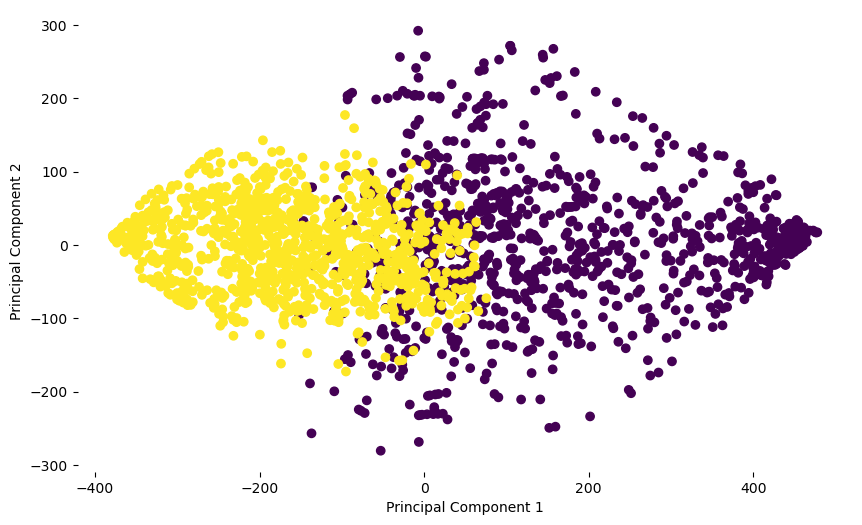

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [5]:
print("Shape of wild_type_latent_flat:", wild_type_latent_flat.shape)
print("Shape of disease_latent_flat:", disease_latent_flat.shape)

Shape of wild_type_latent_flat: (1024, 50176)
Shape of disease_latent_flat: (1024, 50176)


In [12]:
mean_wt_latent = torch.mean(wild_type_latent, dim=0)  
mean_disease_latent = torch.mean(disease_latent, dim=0) 

distance = torch.norm(mean_wt_latent - mean_disease_latent)

print(f"Distance between mean wt and disease latent representations: {distance:.2f}")


Distance between mean wt and disease latent representations: 331.09


In [31]:
import sklearn
print(sklearn.__version__)
from sklearn.manifold import TSNE

1.2.2


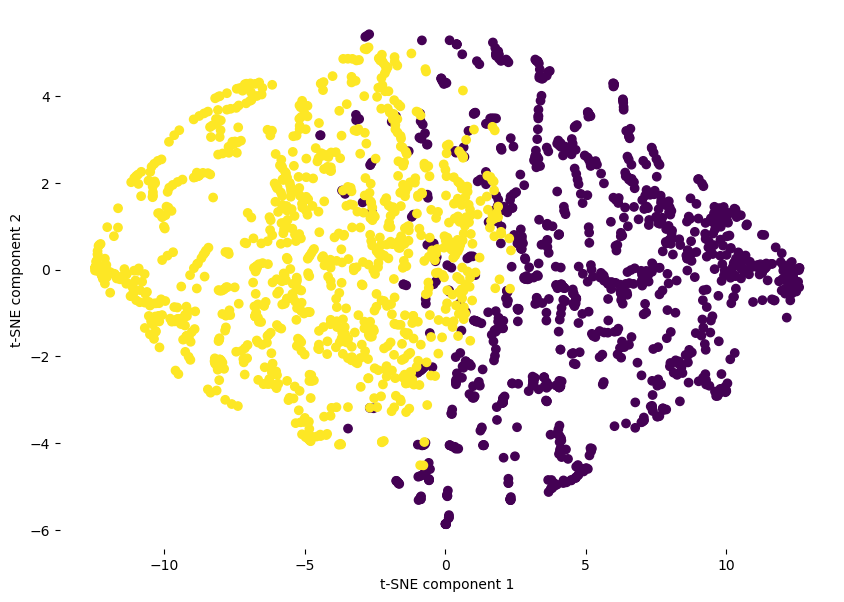

In [33]:
def plot_tsne(data, labels, title="t-SNE plot"):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_result = tsne.fit_transform(data)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


    plt.show()

plot_tsne(pca_result, labels)

In [35]:
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.cluster import KMeans

def calculate_purity(labels, cluster_labels):
    contingency_matrix = np.zeros((np.unique(labels).size, np.unique(cluster_labels).size))
    for i in range(labels.size):
        contingency_matrix[labels[i], cluster_labels[i]] += 1
    purity = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
    return purity


kmeans = KMeans(n_clusters=2)
kmeans.fit(pca_result)
cluster_labels = kmeans.labels_

purity = calculate_purity(labels.astype(int), cluster_labels)
print("Cluster Purity:", purity)


wild_type_centroid = np.mean(pca_result[labels == 0], axis=0)
disease_centroid = np.mean(pca_result[labels == 1], axis=0)
inter_cluster_distance = np.linalg.norm(wild_type_centroid - disease_centroid)
print("Inter-cluster Distance:", inter_cluster_distance)

intra_cluster_distances = []
for label in np.unique(labels):
    cluster_points = pca_result[labels == label]
    centroid = np.mean(cluster_points, axis=0)
    intra_cluster_distances.append(np.mean(np.linalg.norm(cluster_points - centroid, axis=1)))

print("Intra-cluster Distances:", intra_cluster_distances)


/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/threadpoolctl.py:762: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Cluster Purity: 0.845703125
Inter-cluster Distance: 331.01218
Intra-cluster Distances: [232.65936, 141.9625]


In [36]:
def calculate_separation_distance(pca_result, labels):
    
    wild_type_centroid = np.mean(pca_result[labels == 0], axis=0)
    disease_centroid = np.mean(pca_result[labels == 1], axis=0)

    wild_type_to_disease_distances = np.linalg.norm(pca_result[labels == 0] - disease_centroid, axis=1)
   
    disease_to_wild_type_distances = np.linalg.norm(pca_result[labels == 1] - wild_type_centroid, axis=1)

  
    all_distances = np.concatenate((wild_type_to_disease_distances, disease_to_wild_type_distances))
    
    
    separation_distance = np.mean(all_distances)
    
    return separation_distance

separation_distance = calculate_separation_distance(pca_result, labels)
print("Separation Distance:", separation_distance)


Separation Distance: 367.3355


In [17]:
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch

rescue_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_rescue_DAPI_cas3aact-staining_AACT_rescue/')
rescue_latent_vectors = []

def extract_latent_vectors_rescue(model, dataloader, num_samples=10):
    latent_vectors = []
    count = 0
    for batch in dataloader:
        if count >= num_samples:
            break
        batch = batch.to(device)
        with torch.no_grad():
            latent_vector = model.encoder(batch)
        latent_vectors.append(latent_vector)
        count += batch.size(0)
    return torch.cat(latent_vectors)


class CustomDataset(Dataset):
    def __init__(self, data_dir, contrast_factor=9.5):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.contrast_factor = contrast_factor  

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.data_dir, self.image_files[idx])
        try:
            image = self.transform(Image.open(image_name))
            return image
        except OSError as e:
            print(f"Error opening image file {image_name}: {str(e)}")
            return None  

rescue_dataset = CustomDataset(rescue_path)


rescue_dataset = [x for x in rescue_dataset if x is not None]

rescue_dataloader = DataLoader(rescue_dataset, batch_size=32, shuffle=True)


num_rescue_samples = 10000
rescue_latent = extract_latent_vectors_rescue(model, rescue_dataloader, num_rescue_samples)


rescue_latent_flat = rescue_latent.view(rescue_latent.size(0), -1).cpu().numpy()


Error opening image file /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_rescue_DAPI_cas3aact-staining_AACT_rescue/r06c08_r06c08f24p25.tiff: image file is truncated (1744 bytes not processed)
Error opening image file /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_rescue_DAPI_cas3aact-staining_AACT_rescue/r06c08_r06c08f10p24.tiff: image file is truncated (1744 bytes not processed)


In [ ]:
#Image Reconstruction

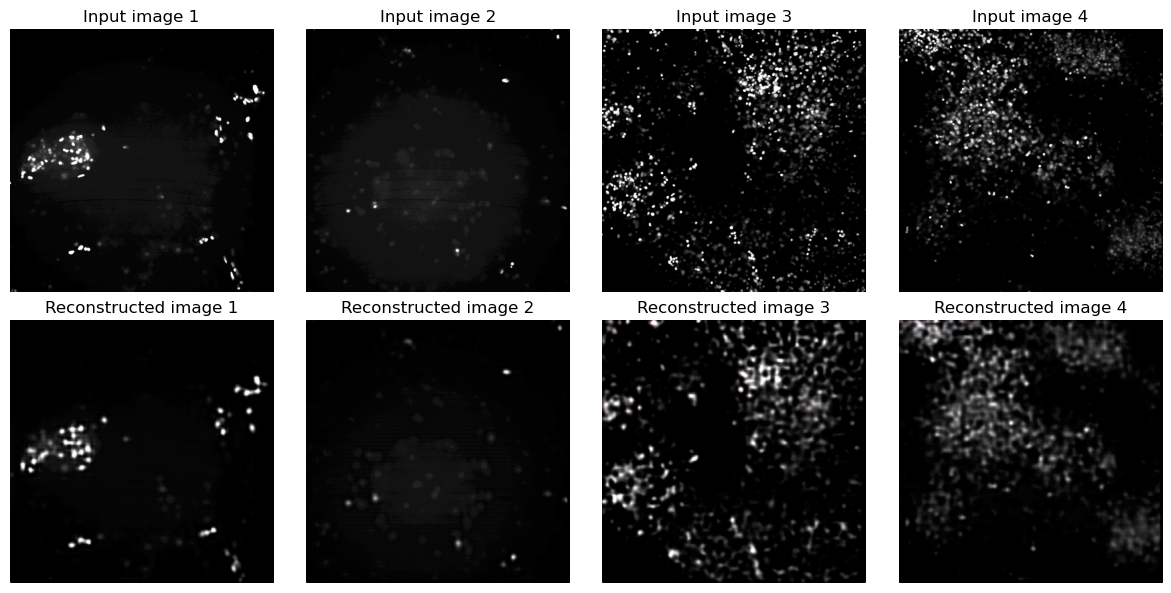

In [13]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageEnhance
import random
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, data_dir, contrast_factor=4.0):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.contrast_factor = contrast_factor   

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(image_name)
        
        
        image = ImageEnhance.Contrast(image).enhance(self.contrast_factor)
        
        image = self.transform(image)
        return image



loaded_model = Autoencoder()
loaded_model.load_state_dict(torch.load('trained_model_con_dapi.pth'))
loaded_model.eval()

def enhance_contrast(image, enhancement_factor=5):
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(enhancement_factor)
    return enhanced_image

path_list = [
    '/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_RGB_disease_DAPI_(cas3aact)-stainingdisease_AACT/',
    '/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/single_RGB_wt_DAPI_(cas3aact)-stainingwild_typeAACT/'
]
selected_path = random.choice(path_list)

image_files = os.listdir(selected_path)
random_image_files = random.sample(image_files, 4)

plt.figure(figsize=(12, 6))
for i, image_file in enumerate(random_image_files, 1):
    input_image_path = os.path.join(selected_path, image_file)
    input_image = Image.open(input_image_path)
    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)  

    
    with torch.no_grad():
        latent_vector = loaded_model.encoder(input_tensor)

    reconstructed_image = loaded_model.decoder(latent_vector)  

    input_pil_image = transforms.ToPILImage()(input_tensor.squeeze(0))
    reconstructed_pil_image = transforms.ToPILImage()(reconstructed_image.squeeze(0))

    enhanced_input_image = enhance_contrast(input_pil_image, enhancement_factor=14.5)
    enhanced_reconstructed_image = enhance_contrast(reconstructed_pil_image, enhancement_factor=14.5)

    plt.subplot(2, 4, i)
    plt.imshow(enhanced_input_image)
    plt.axis("off")
    plt.title(f"Input image {i}")

    plt.subplot(2, 4, i + 4)
    plt.imshow(enhanced_reconstructed_image)
    plt.axis("off")
    plt.title(f"Reconstructed image {i}")

plt.tight_layout()
plt.show()


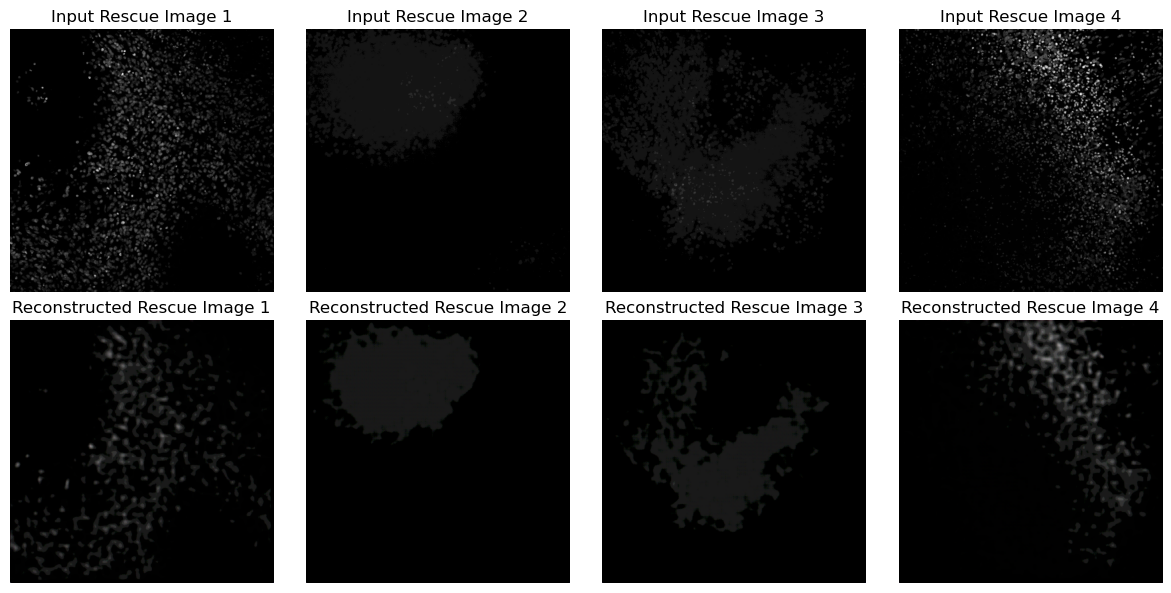

In [16]:
selected_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_rescue_DAPI_cas3aact-staining_AACT_rescue/')
rescue_latent_vectors = []
image_files = os.listdir(selected_path)
random_image_files = random.sample(image_files, 4)

plt.figure(figsize=(12, 6))
for i, image_file in enumerate(random_image_files, 1):
    input_image_path = os.path.join(selected_path, image_file)
    input_image = Image.open(input_image_path)
    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)  

    
    with torch.no_grad():
        latent_vector = loaded_model.encoder(input_tensor)

    reconstructed_image = loaded_model.decoder(latent_vector)  

    input_pil_image = transforms.ToPILImage()(input_tensor.squeeze(0))
    reconstructed_pil_image = transforms.ToPILImage()(reconstructed_image.squeeze(0))

    enhanced_input_image = enhance_contrast(input_pil_image, enhancement_factor=20.5)
    enhanced_reconstructed_image = enhance_contrast(reconstructed_pil_image, enhancement_factor=25.5)

    plt.subplot(2, 4, i)
    plt.imshow(enhanced_input_image)
    plt.axis("off")
    plt.title(f"Input Rescue Image {i}")

    plt.subplot(2, 4, i + 4)
    plt.imshow(enhanced_reconstructed_image)
    plt.axis("off")
    plt.title(f"Reconstructed Rescue Image {i}")

plt.tight_layout()
plt.show()


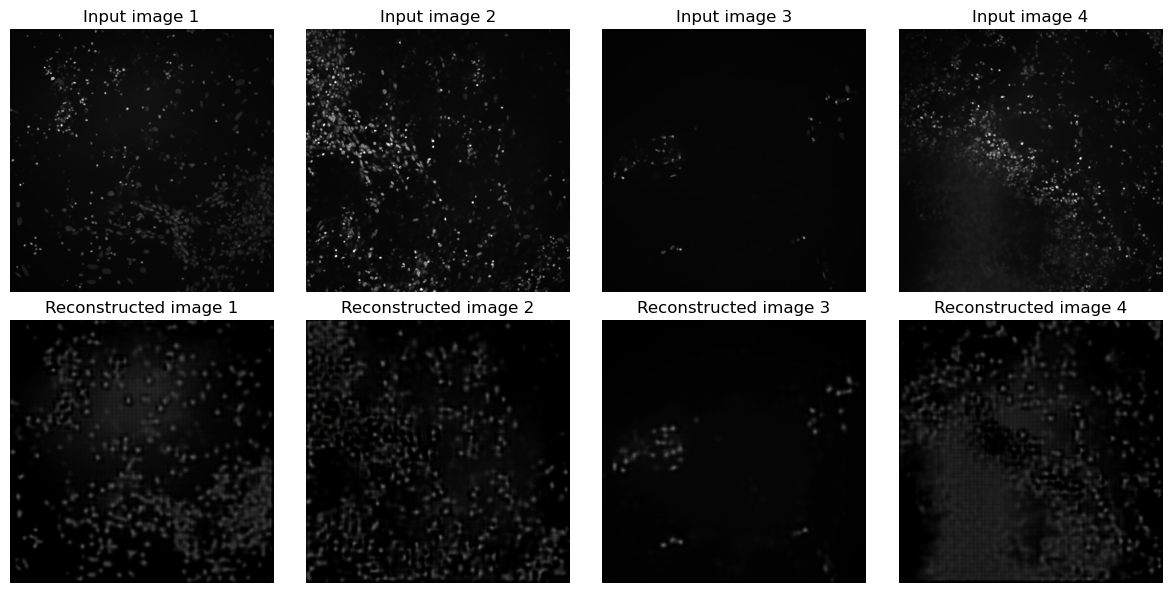

In [23]:
loaded_model = Autoencoder()
loaded_model.load_state_dict(torch.load('trained_model_con_dapi.pth'))
loaded_model.eval()

path_list = [
    '/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_RGB_disease_DAPI_(cas3aact)-stainingdisease_AACT/',
    '/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/single_RGB_wt_DAPI_(cas3aact)-stainingwild_typeAACT/'
]
selected_path = random.choice(path_list)

image_files = os.listdir(selected_path)
random_image_files = random.sample(image_files, 4)

plt.figure(figsize=(12, 6))
for i, image_file in enumerate(random_image_files, 1):
    input_image_path = os.path.join(selected_path, image_file)
    input_image = Image.open(input_image_path)
    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0) 

    
    with torch.no_grad():
        latent_vector = loaded_model.encoder(input_tensor)

    reconstructed_image = loaded_model.decoder(latent_vector) 

    input_pil_image = transforms.ToPILImage()(input_tensor.squeeze(0))
    
   
    reconstructed_pil_image = transforms.ToPILImage()(reconstructed_image.squeeze(0))
    enhanced_reconstructed_pil_image = ImageEnhance.Contrast(reconstructed_pil_image).enhance(3.0)  

    plt.subplot(2, 4, i)
    plt.imshow(input_pil_image)
    plt.axis("off")
    plt.title(f"Input image {i}")

    plt.subplot(2, 4, i + 4)
    plt.imshow(enhanced_reconstructed_pil_image)
    plt.axis("off")
    plt.title(f"Reconstructed image {i}")

plt.tight_layout()
plt.show()

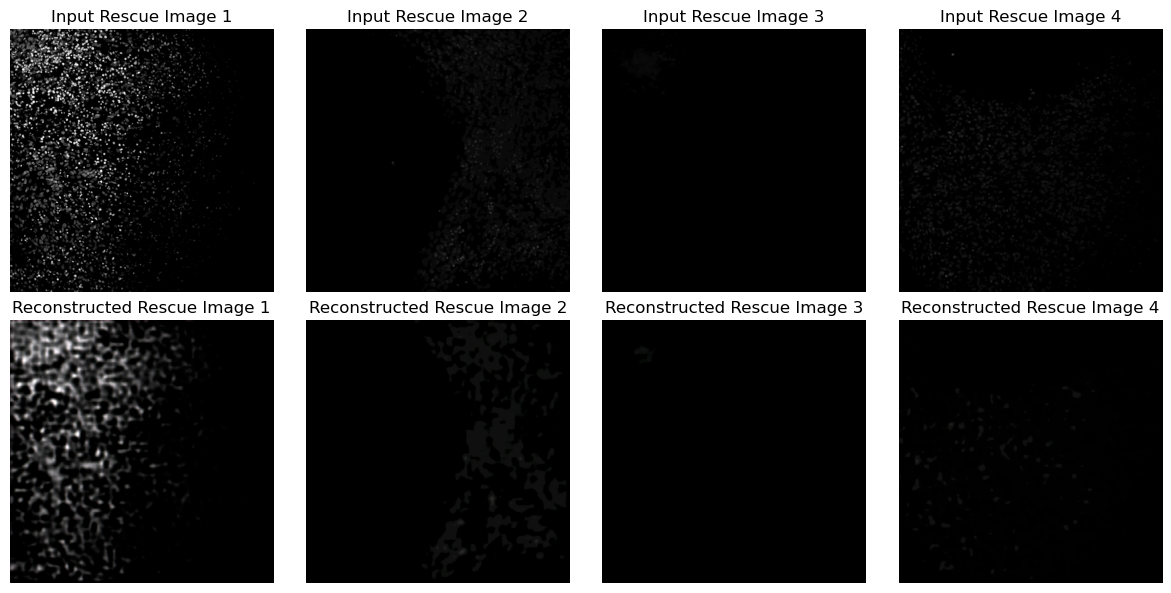

In [39]:
selected_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/single_rescue_DAPI_cas3aact-staining_AACT_rescue/')
rescue_latent_vectors = []
image_files = os.listdir(selected_path)
random_image_files = random.sample(image_files, 4)

plt.figure(figsize=(12, 6))
for i, image_file in enumerate(random_image_files, 1):
    input_image_path = os.path.join(selected_path, image_file)
    input_image = Image.open(input_image_path)
    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)  

   
    with torch.no_grad():
        latent_vector = loaded_model.encoder(input_tensor)

    reconstructed_image = loaded_model.decoder(latent_vector)  

    input_pil_image = transforms.ToPILImage()(input_tensor.squeeze(0))
    reconstructed_pil_image = transforms.ToPILImage()(reconstructed_image.squeeze(0))

    enhanced_input_image = enhance_contrast(input_pil_image, enhancement_factor=10.5)
    enhanced_reconstructed_image = enhance_contrast(reconstructed_pil_image, enhancement_factor=15.5)

    plt.subplot(2, 4, i)
    plt.imshow(enhanced_input_image)
    plt.axis("off")
    plt.title(f"Input Rescue Image {i}")

    plt.subplot(2, 4, i + 4)
    plt.imshow(enhanced_reconstructed_image)
    plt.axis("off")
    plt.title(f"Reconstructed Rescue Image {i}")

plt.tight_layout()
plt.show()